# Using Google Maps: Where will Crime Happen Next in San Francisco? Let's Predict and Map It on Google Cloud

Note: you can install the requirements file for this notebook if you want to install all the libraries at once. Open a new terminal window, navigate to the folder with the "requirements_jupyter.txt" and run the following command:

***pip3 install -r requirements_jupyter.txt***

In [1]:
import numpy as np 
import pandas as pd 
import datetime
import urllib
import matplotlib.pyplot as plt

# SF Crime Heat Map
### https://data.sfgov.org/Public-Safety/SF-Crime-Heat-Map/q6gg-sa2p/data

In [2]:
# Get crime data and save a local copy, the first time around, then set the
# already_have_the_data flag to False to download the local copy as it is 
# a large file and can be very slow to download!
already_have_the_data = False
if not already_have_the_data:
    # downloading directly from the internet
    crime_df_raw = pd.read_csv('https://data.sfgov.org/api/views/q6gg-sa2p/rows.csv?accessType=DOWNLOAD')
    crime_df_raw.to_csv('SF-Crime-Heat-Map.csv', index=False)
else:
    # get crime data - save a local copy as it is a lot of data
    crime_df_raw = pd.read_csv('SF-Crime-Heat-Map.csv')

In [57]:
crime_df_raw.head(3)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)"
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)"
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)"


In [58]:
crime_df = crime_df_raw.copy()
list(crime_df)

['IncidntNum',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Location']

In [59]:
crime_df.shape

(2215024, 12)

In [60]:
years = [int(dte.split("/")[2]) for dte in crime_df['Date']]
print('Max year %i, min year %i' % (max(years), min(years)))

Max year 2018, min year 2003


# Dataset Cleanup
Remove useless columns and rename X,Y to Longitude and Latitude# Dataset Cleanup
Remove useless columns and rename X,Y to Longitude and Latitude

In [61]:
crime_df = crime_df[['Category', 'DayOfWeek', 'Date', 'Time', 'X', 'Y']]

# Rename X,Y to Longitude, Latitude
crime_df.columns = ['Category', 'DayOfWeek', 'Date', 'Time', 'Longitude', 'Latitude']
crime_df.head()

,Category,DayOfWeek,Date,Time,Longitude,Latitude
0,NON-CRIMINAL,Monday,01/19/2015,14:00,-122.421582,37.761701
1,ROBBERY,Sunday,02/01/2015,15:45,-122.414406,37.784191
2,ASSAULT,Sunday,02/01/2015,15:45,-122.414406,37.784191
3,SECONDARY CODES,Sunday,02/01/2015,15:45,-122.414406,37.784191
4,VANDALISM,Tuesday,01/27/2015,19:00,-122.431119,37.800469


# Data Exploration

In [62]:
crime_df['Category'].value_counts() 

LARCENY/THEFT                  480448
OTHER OFFENSES                 309358
NON-CRIMINAL                   238323
ASSAULT                        194694
VEHICLE THEFT                  126602
DRUG/NARCOTIC                  119628
VANDALISM                      116059
WARRANTS                       101379
BURGLARY                        91543
SUSPICIOUS OCC                  80444
MISSING PERSON                  64961
ROBBERY                         55867
FRAUD                           41542
SECONDARY CODES                 25831
FORGERY/COUNTERFEITING          23050
WEAPON LAWS                     22234
TRESPASS                        19449
PROSTITUTION                    16701
STOLEN PROPERTY                 11891
SEX OFFENSES, FORCIBLE          11742
DISORDERLY CONDUCT              10040
DRUNKENNESS                      9826
RECOVERED VEHICLE                8716
DRIVING UNDER THE INFLUENCE      5672
KIDNAPPING                       5346
RUNAWAY                          4440
LIQUOR LAWS 

# Re-Balancing the Dataset
## Fix categories and create a master category dictionary  
Create 4 groups
- THEFT
- IMPAIRED
- VIOLENCE
- OTHER

In [63]:
# group by types
THEFT = ["LARCENY/THEFT", "VEHICLE THEFT", "BURGLARY", "ROBBERY", "STOLEN PROPERTY"]
IMPAIRED = ["DRUNKENNESS", "DRIVING UNDER THE INFLUENCE", "LIQUOR LAWS", "DISORDERLY CONDUCT", "DRUG/NARCOTIC", "LOITERING"]
VIOLENCE = ["ASSAULT", "VANDALISM", "SUSPICIOUS OCC", "TRESPASS", "SEX OFFENSES, FORCIBLE" , "SEX OFFENSES, NON FORCIBLE"] 
OTHER = ["OTHER OFFENSES", "NON-CRIMINAL"]


CATEGORIES = THEFT + IMPAIRED + VIOLENCE + OTHER
crime_df = crime_df[crime_df['Category'].isin(CATEGORIES)]


# create new super groups
selections = [
    (crime_df['Category'].isin(THEFT)),
    (crime_df['Category'].isin(IMPAIRED)),
    (crime_df['Category'].isin(VIOLENCE)),
    (crime_df['Category'].isin(OTHER))] 

new_categories = ['THEFT', 'IMPAIRED', 'VIOLENCE', 'OTHER']
crime_df['CAT'] = np.select(selections, new_categories, default='OTHER')
crime_df['CAT'].value_counts()
 



THEFT       766351
OTHER       547681
VIOLENCE    422819
IMPAIRED    151679
Name: CAT, dtype: int64

# Exploring By DayOfWeek

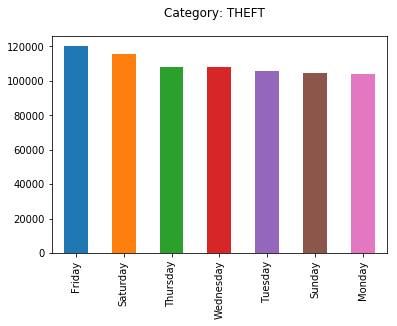

In [64]:

crime_df_tmp = crime_df[crime_df['CAT'] == 'THEFT']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: THEFT')
plt.show()

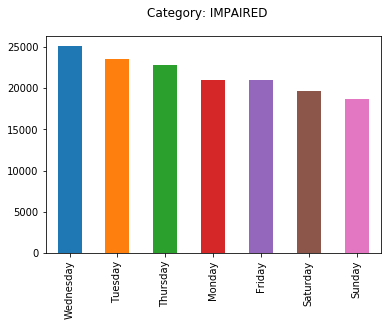

In [65]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: IMPAIRED')
plt.show()

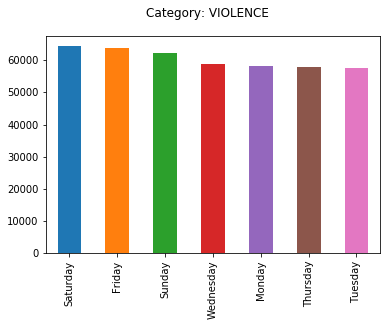

In [66]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: VIOLENCE')
plt.show()

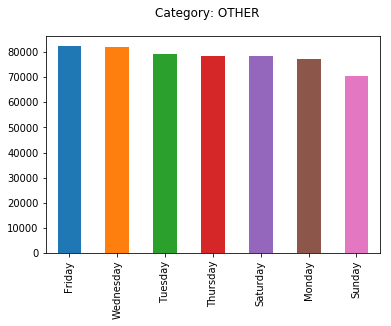

In [67]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'OTHER']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: OTHER')
plt.show()

# Feature Engineering

### Day of month

In [68]:
crime_df["Day_of_month"] = [int(dte.split("/")[1]) for dte in crime_df['Date']]

In [69]:
### Month of year

In [70]:
crime_df["Month_of_year"] = [int(dte.split("/")[0]) for dte in crime_df['Date']]
crime_by_month = pd.DataFrame(crime_df["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
crime_by_month

,Month_of_year
1,167666
2,151502
3,168126
4,161556
5,159885
6,148957
7,155609
8,160499
9,156831
10,162538


In [71]:
crime_by_month['Month_of_year']

1     167666
2     151502
3     168126
4     161556
5     159885
6     148957
7     155609
8     160499
9     156831
10    162538
11    149342
12    146019
Name: Month_of_year, dtype: int64

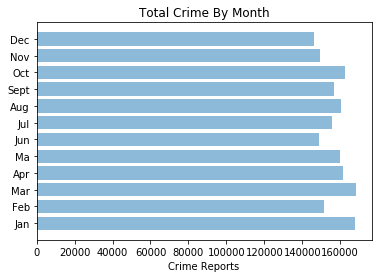

In [72]:
plt.barh(crime_by_month.index, crime_by_month['Month_of_year'], align='center', alpha=0.5)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('Total Crime By Month')
plt.show()

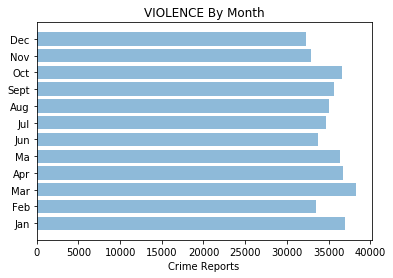

In [73]:
crime_by_month = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
plt.barh(crime_by_month.index, crime_by_month['Month_of_year'], align='center', alpha=0.5)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Month')
plt.show()

 

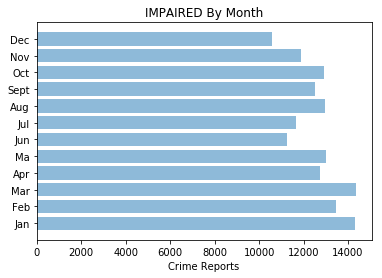

In [74]:
crime_by_month = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
plt.barh(crime_by_month.index, crime_by_month['Month_of_year'], align='center', alpha=0.5)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Month')
plt.show()


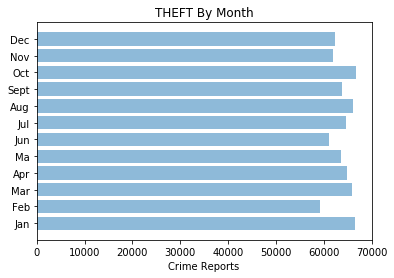

In [75]:
crime_by_month = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
plt.barh(crime_by_month.index, crime_by_month['Month_of_year'], align='center', alpha=0.5)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('THEFT By Month')
plt.show()

# Year

In [76]:
crime_df["Year"] = [int(dte.split("/")[2]) for dte in crime_df['Date']]

### Day Of The Week

In [77]:
# Transform day of week into ordered numbers 
selections = [
    (crime_df['DayOfWeek']=='Monday'),
    (crime_df['DayOfWeek']=='Tuesday'),
    (crime_df['DayOfWeek']=='Wednesday'),
    (crime_df['DayOfWeek']=='Thursday'),
    (crime_df['DayOfWeek']=='Friday'),
    (crime_df['DayOfWeek']=='Saturday'),
    (crime_df['DayOfWeek']=='Sunday')] 

new_categories = [1,2,3,4,5,6,7]
crime_df['Day_of_week'] = np.select(selections, new_categories, default=7)
 
crime_by_day = pd.DataFrame(crime_df["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index()
crime_by_day

,Day_of_week
1,260497
2,266115
3,273839
4,267157
5,287167
6,277755
7,256000


In [78]:
crime_by_day = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index()
crime_by_day

,Day_of_week
1,58162
2,57681
3,58880
4,57718
5,63804
6,64327
7,62247


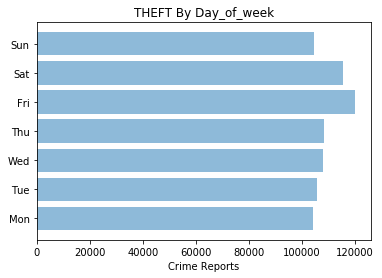

In [79]:
crime_by_day = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 

plt.barh(crime_by_day.index, crime_by_day['Day_of_week'], align='center', alpha=0.5)
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day.index, objects)
plt.xlabel('Crime Reports')
plt.title('THEFT By Day_of_week')
plt.show()

 


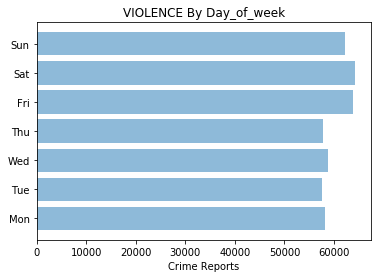

In [80]:
crime_by_day = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 

plt.barh(crime_by_day.index, crime_by_day['Day_of_week'], align='center', alpha=0.5)
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day.index, objects)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Day_of_week')
plt.show()


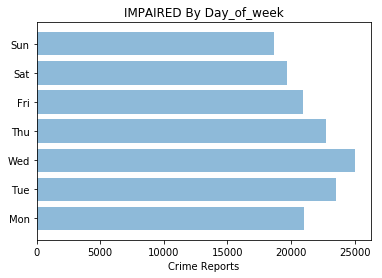

In [81]:
crime_by_day = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 

plt.barh(crime_by_day.index, crime_by_day['Day_of_week'], align='center', alpha=0.5)
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day.index, objects)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Day_of_week')
plt.show()

In [82]:
crime_by_month["Month_of_year"]

1     66583
2     59249
3     65824
4     64847
5     63518
6     60993
7     64680
8     66126
9     63701
10    66633
11    61900
12    62297
Name: Month_of_year, dtype: int64

# Geo coordinates 

In [83]:
crime_df["Longitude"].describe()

count    1.888530e+06
mean    -1.224230e+02
std      2.985543e-02
min     -1.225136e+02
25%     -1.224333e+02
50%     -1.224167e+02
75%     -1.224069e+02
max     -1.205000e+02
Name: Longitude, dtype: float64

In [84]:
crime_df["Latitude"].describe()

count    1.888530e+06
mean     3.777127e+01
std      4.204831e-01
min      3.770788e+01
25%      3.775363e+01
50%      3.777542e+01
75%      3.778470e+01
max      9.000000e+01
Name: Latitude, dtype: float64

### Remove Geo-coords Outliers

In [85]:
# plot geocords
# remove edge coordinates / outliers 
q = crime_df["Longitude"].quantile(0.95)
crime_df = crime_df[crime_df["Longitude"] < q]
q = crime_df["Latitude"].quantile(0.95)
crime_df = crime_df[crime_df["Latitude"] < q]
crime_df["Latitude"].describe()

count    1.704269e+06
mean     3.776727e+01
std      2.252819e-02
min      3.770788e+01
25%      3.775544e+01
50%      3.777542e+01
75%      3.778396e+01
max      3.779944e+01
Name: Latitude, dtype: float64

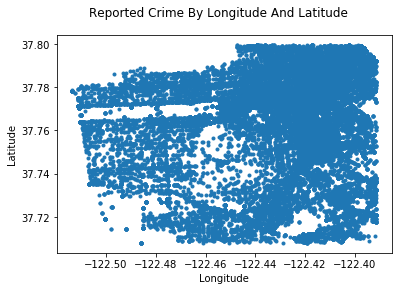

In [86]:
plt.plot(crime_df['Longitude'].head(50000), 
         crime_df['Latitude'].head(50000),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime By Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

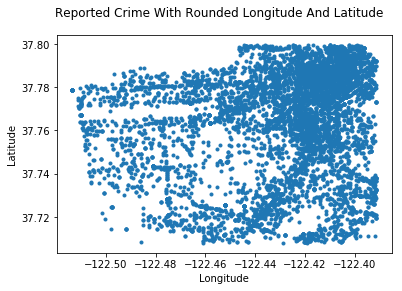

In [87]:
rounding_factor = 4
plt.plot(np.round(crime_df['Longitude'].head(10000),rounding_factor), 
         np.round(crime_df['Latitude'].head(10000),rounding_factor),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime With Rounded Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

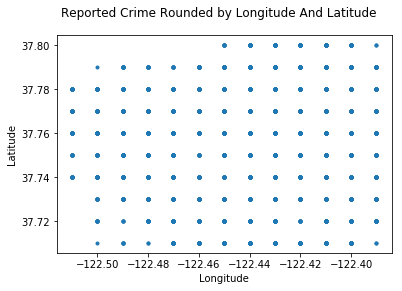

In [88]:
rounding_factor = 2
plt.plot(np.round(crime_df['Longitude'].head(10000),rounding_factor), 
         np.round(crime_df['Latitude'].head(10000),rounding_factor),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime Rounded by Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Create heatmap


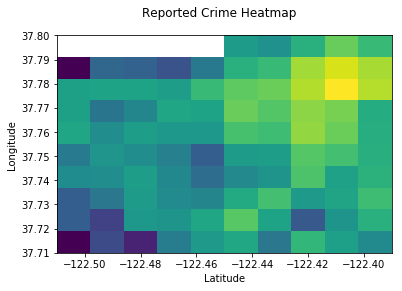

In [89]:
# Create heatmap
from matplotlib.colors import LogNorm
x = np.round(crime_df['Longitude'].head(10000),rounding_factor)
y = np.round(crime_df['Latitude'].head(10000),rounding_factor)
fig = plt.figure()
plt.suptitle('Reported Crime Heatmap')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
H, xedges, yedges, img = plt.hist2d(x, y, norm=LogNorm())
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]



#ax = fig.add_subplot(1, 1, 1)
#im = ax.imshow(H, cmap=plt.cm.jet, extent=extent, norm=LogNorm())

plt.show()

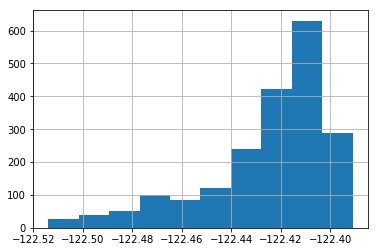

In [90]:
crime_df['Longitude'] = np.round(crime_df['Longitude'],3)
crime_df['Latitude'] = np.round(crime_df['Latitude'],3)
crime_df['Longitude'].head(2000).hist()
plt.show()

# Time Segments

### Create AM, AFT, NT

In [91]:
# create AM, AFT, NT
crime_df["Hour"] = [int(hr.split(":")[0]) for hr in crime_df['Time']]
crime_df["Hour"]

# create new super groups
selections = [
    (crime_df['Hour'] > 5) & (crime_df['Hour'] <=13),
    (crime_df['Hour']  > 13) & (crime_df['Hour'] <= 19),
    (crime_df['Hour']  > 18) & (crime_df['Hour'] <= 5)] 

new_categories = [0, 1, 2] # ['AM', 'AFT', 'NIT']
time_segment_names = ['AM','AFT','NIT']
crime_df['Day_Segment'] = np.select(selections, new_categories, default=2)
crime_df['Day_Segment'].value_counts()


2    597050
1    586101
0    521118
Name: Day_Segment, dtype: int64

In [92]:
crime_df.head()

,Category,DayOfWeek,Date,Time,Longitude,Latitude,CAT,Day_of_month,Month_of_year,Year,Day_of_week,Hour,Day_Segment
0,NON-CRIMINAL,Monday,01/19/2015,14:00,-122.422,37.762,OTHER,19,1,2015,1,14,1
1,ROBBERY,Sunday,02/01/2015,15:45,-122.414,37.784,THEFT,1,2,2015,7,15,1
2,ASSAULT,Sunday,02/01/2015,15:45,-122.414,37.784,VIOLENCE,1,2,2015,7,15,1
5,NON-CRIMINAL,Sunday,02/01/2015,16:21,-122.452,37.787,OTHER,1,2,2015,7,16,1
8,BURGLARY,Saturday,01/31/2015,16:09,-122.407,37.788,THEFT,31,1,2015,6,16,1


## Plot time segments by crime

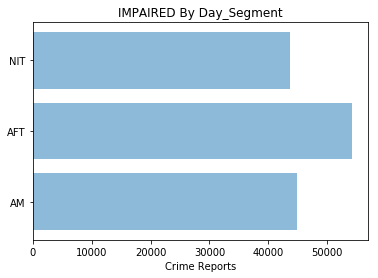

In [93]:
crime_by_time = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 

plt.barh(crime_by_time.index, crime_by_time["Day_Segment"], align='center', alpha=0.5)
plt.yticks(crime_by_time.index, time_segment_names)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Day_Segment')
plt.show()

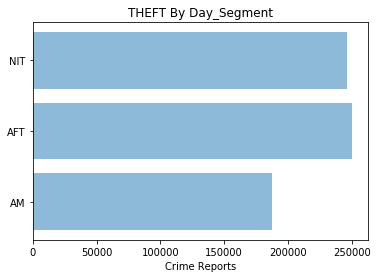

In [94]:
crime_by_time = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 

plt.barh(crime_by_time.index, crime_by_time["Day_Segment"], align='center', alpha=0.5)
plt.yticks(crime_by_time.index, time_segment_names)
plt.xlabel('Crime Reports')
plt.title('THEFT By Day_Segment')
plt.show()

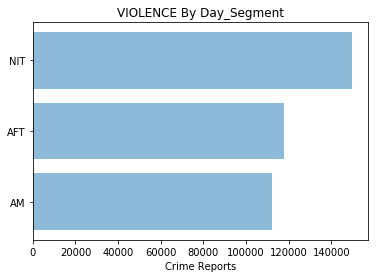

In [95]:
crime_by_time = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 

plt.barh(crime_by_time.index, crime_by_time["Day_Segment"], align='center', alpha=0.5)
plt.yticks(crime_by_time.index, time_segment_names)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Day_Segment')
plt.show()

# Final features for model

In [96]:
crime_df = crime_df[['CAT', 'Day_of_month','Month_of_year', 'Day_Segment', 'Longitude', 'Latitude', 'Year']]

In [97]:
crime_df.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year
0,OTHER,19,1,1,-122.422,37.762,2015
1,THEFT,1,2,1,-122.414,37.784,2015
2,VIOLENCE,1,2,1,-122.414,37.784,2015
5,OTHER,1,2,1,-122.452,37.787,2015
8,THEFT,31,1,1,-122.407,37.788,2015


# Creating Crime Estimates 

## Aggregating data down to time and location

In [98]:
# aggregate data with groupby
crime_df.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year
0,OTHER,19,1,1,-122.422,37.762,2015
1,THEFT,1,2,1,-122.414,37.784,2015
2,VIOLENCE,1,2,1,-122.414,37.784,2015
5,OTHER,1,2,1,-122.452,37.787,2015
8,THEFT,31,1,1,-122.407,37.788,2015


In [99]:
list(crime_df)

['CAT',
 'Day_of_month',
 'Month_of_year',
 'Day_Segment',
 'Longitude',
 'Latitude',
 'Year']

In [100]:
crime_df['Count'] = 0

In [101]:

crime_df_agg = crime_df[crime_df['Year'] >= 2017]

crime_df_agg = crime_df_agg.groupby(['CAT', 'Day_of_month', 'Month_of_year',  'Day_Segment', 
                                 'Longitude',  'Latitude',]).count().reset_index()

# we will use this csv file in our web application (though there is already one in the downloads for the chapter)
crime_df_agg.to_csv('sf-crime-horizon.csv', index=None)


In [102]:
crime_df_agg.tail()
 

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year,Count
134444,VIOLENCE,31,12,2,-122.404,37.754,1,1
134445,VIOLENCE,31,12,2,-122.404,37.784,1,1
134446,VIOLENCE,31,12,2,-122.403,37.775,2,2
134447,VIOLENCE,31,12,2,-122.403,37.785,1,1
134448,VIOLENCE,31,12,2,-122.396,37.754,1,1


# Reconstructing Crime Maps By Time Signature
This is the part where we throw in a date, and see what it returns. We'll use a similar concept in the web application but it will be controlled by a slider. 



In [103]:
Day_of_month = 1
Month_of_year = 1
Day_Segment = 2
crime_df_agg_tmp = crime_df_agg[(crime_df_agg['Day_of_month'] == Day_of_month) &
                               (crime_df_agg['Month_of_year'] == Month_of_year) &
                                 (crime_df_agg['Day_Segment'] == Day_Segment)]
crime_df_agg_tmp.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year,Count
8,IMPAIRED,1,1,2,-122.475,37.721,1,1
9,IMPAIRED,1,1,2,-122.460,37.755,2,2
10,IMPAIRED,1,1,2,-122.448,37.770,2,2
11,IMPAIRED,1,1,2,-122.435,37.797,1,1
12,IMPAIRED,1,1,2,-122.431,37.761,1,1


In [104]:
import datetime
monthinteger = Month_of_year
Month_Name = datetime.date(1900, monthinteger, 1).strftime('%B')
    

# translate time signature into readable format
title = "Crime Estimates For %s %s %s" % (Month_Name, Day_of_month, time_segment_names[Day_Segment])


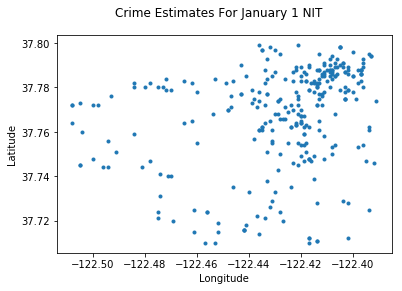

In [105]:
plt.plot(crime_df_agg_tmp['Longitude'] , 
         crime_df_agg_tmp['Latitude'] ,
         linestyle='none', marker='.')
plt.suptitle(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

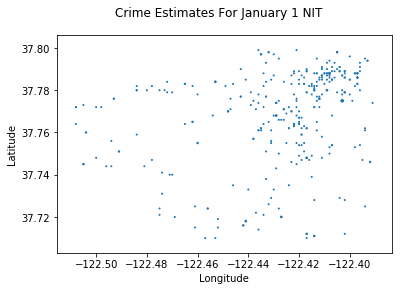

In [106]:
# Using plot.scatter to benefit from size of dot
plt.scatter(crime_df_agg_tmp['Longitude'] , 
         crime_df_agg_tmp['Latitude'] , s=crime_df_agg_tmp['Count'])
plt.suptitle(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Creating crime points for Google Maps

In [107]:
crime_df_agg_tmp['Longitude'].head()

8    -122.475
9    -122.460
10   -122.448
11   -122.435
12   -122.431
Name: Longitude, dtype: float64

In [108]:
# create new Google maps LatLng string
# Google LatLng format: new google.maps.LatLng(37.770467, -122.409801), new google.maps.LatLng(37.770090, -122.408904),
LatLngString = ''
for index, row in crime_df_agg_tmp.iterrows():
    LatLngString += "new google.maps.LatLng(" + str(row['Latitude']) + "," + str(row['Longitude']) + "),"
     
     

## Abstracting Code Into A Function For Our Web Appliction

In [109]:
crime_horizon_df = pd.read_csv('sf-crime-horizon.csv')
 

def GetCrime(horizon_date, horizon_time_segment):
    Day_of_month = int(horizon_date.split('/')[1])
    print('Day_of_month:',Day_of_month)
    Month_of_year = int(horizon_date.split('/')[0])
    print('Month_of_year:',Month_of_year)
    Day_Segment = int(horizon_time_segment) # 0,1,2
    print('Day_Segment:',Day_Segment)
    crime_horizon_df_tmp = crime_horizon_df[(crime_horizon_df['Day_of_month'] == Day_of_month) &
                                   (crime_horizon_df['Month_of_year'] == Month_of_year) &
                                     (crime_horizon_df['Day_Segment'] == Day_Segment)]
    
    LatLngString = ''
    # build latlng string for google maps
    for index, row in crime_horizon_df_tmp.iterrows():
        LatLngString += "new google.maps.LatLng(" + str(row['Latitude']) + "," + str(row['Longitude']) + "),"
     
    return (LatLngString)
    
    
preds_crime_horizon = GetCrime('10/10/2018', 0)

Day_of_month: 10
Month_of_year: 10
Day_Segment: 0


In [110]:
preds_crime_horizon[0:1000]

'new google.maps.LatLng(37.724000000000004,-122.436),new google.maps.LatLng(37.77,-122.413),new google.maps.LatLng(37.775,-122.51),new google.maps.LatLng(37.745,-122.506),new google.maps.LatLng(37.765,-122.485),new google.maps.LatLng(37.763000000000005,-122.48100000000001),new google.maps.LatLng(37.746,-122.454),new google.maps.LatLng(37.771,-122.45100000000001),new google.maps.LatLng(37.766999999999996,-122.448),new google.maps.LatLng(37.713,-122.444),new google.maps.LatLng(37.766,-122.44),new google.maps.LatLng(37.778,-122.44),new google.maps.LatLng(37.783,-122.44),new google.maps.LatLng(37.765,-122.428),new google.maps.LatLng(37.753,-122.419),new google.maps.LatLng(37.760999999999996,-122.419),new google.maps.LatLng(37.798,-122.417),new google.maps.LatLng(37.78,-122.415),new google.maps.LatLng(37.783,-122.414),new google.maps.LatLng(37.793,-122.414),new google.maps.LatLng(37.77,-122.413),new google.maps.LatLng(37.771,-122.412),new google.maps.LatLng(37.785,-122.40700000000001),new g